Connect to database and import dependencies

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

conn = sqlite3.connect('data/bmarket.db')

Get the table and store it in raw_df

In [2]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
raw_df: pd.DataFrame = None
for table in tables['name']:
    print(f"Table: {table}")
    query = f"SELECT * FROM {table};"
    raw_df = pd.read_sql_query(query, conn)
    print("\n" + "-" * 50 + "\n")


Table: bank_marketing

--------------------------------------------------



Summarise raw data (shape, non-null count, null%)

Rationale: See what features I'm dealing with and how complete the data is

Right off the bat we can see that there appears to be a lot of null in Housing Loan and Personal Loan.

People who do not declare sensitive information like loans may have some information about them that we can capture in our model. We may have to introduce an 'unknown' group depending on the how our data is distributed and correlated.

In [3]:
print(raw_df.info())
def print_null_percent(df: pd.DataFrame):
    null_percent = (df.isnull().sum() / len(df)) * 100
    null_percent = null_percent.apply(lambda x: f'{x:.2f}%')
    print(null_percent)
print()
print_null_percent(raw_df)
print()
print(raw_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB
None

Client ID                 0.00%
Age                       0.00%
Occupation                0.00%
Marital Status           

Summarise raw data (all unique column values)

Rationale: See what my data looks like so I know how I should process the data if needed

I'll need to do a lot of processing which will be explained below.

In [4]:
def print_column_uniques(df: pd.DataFrame):
    for col in df.columns:
        print(f"Column: {col}")
        print(df[col].unique())
        print()
print_column_uniques(raw_df)

Column: Client ID
[32885  3170 32207 ... 38159   861 15796]

Column: Age
['57 years' '55 years' '33 years' '36 years' '27 years' '58 years'
 '48 years' '150 years' '24 years' '34 years' '42 years' '43 years'
 '26 years' '37 years' '46 years' '59 years' '49 years' '30 years'
 '51 years' '45 years' '31 years' '41 years' '38 years' '47 years'
 '69 years' '50 years' '25 years' '39 years' '44 years' '52 years'
 '35 years' '77 years' '40 years' '56 years' '53 years' '60 years'
 '29 years' '28 years' '54 years' '32 years' '81 years' '63 years'
 '21 years' '22 years' '74 years' '80 years' '62 years' '68 years'
 '86 years' '23 years' '71 years' '67 years' '65 years' '20 years'
 '19 years' '66 years' '75 years' '18 years' '72 years' '70 years'
 '82 years' '85 years' '61 years' '88 years' '83 years' '78 years'
 '64 years' '17 years' '76 years' '73 years' '79 years' '89 years'
 '84 years' '91 years' '98 years' '92 years' '95 years']

Column: Occupation
['technician' 'unknown' 'blue-collar' 'admin.

Process raw_df into processed_df

Remove "Client ID" as it's not relevant to predictions.

Replace "Age" with "Age (years)". Easier to handle numerical data. We can get statistics like mean, std, and quartiles more easily.
Also remove anyone older than 122 years and with negative age because those are false data.

Generally, for values that we do not know, we'll use NA or NaN as most frameworks like scikit-learn can easily detect the values and replace them for us. 

Convert "Credit Default", "Housing Loan", "Personal Loan", and "Subscription Status" to boolean.

Convert "Contact Method" to lowercase and change similar values to same values.
This lets the model see similar as same which is what they are.

For "Campaign Calls", -ve calls do not make any sense. There was probably some mishandling of information. I need to visualize the data first to see if I need to maybe drop rows or convert the -ve to +ve.
In practice, I'd probably take a look at the code/survey that was used to get the information. Perhaps someone put an extra minus sign by mistake in gathering data from a certain place instead of pressing backspace? 

Convert numbers gte 999 in "Previous Contact Days" to NaN. This column will now be interpreted as NaN if did not have contact within 999 days. This is to clearly separate the rows with x >= 999 from those with x < 999 in the eyes of the model.

Convert "Subscription Status" to boolean.

Rename "Subscription Status" to "target"

In [68]:
processed_df = raw_df.copy()
target = 'target'

# Client ID
processed_df.drop('Client ID', axis=1, inplace=True)

# Age
processed_df['Age'] = processed_df['Age'].str.extract(r'(\d+)').astype(int)
processed_df.rename(columns={'Age': 'Age (years)'}, inplace=True)
processed_df = processed_df[(processed_df['Age (years)'] >= 0) & (processed_df['Age (years)'] <= 122)]

# All 'unknown' to None first
processed_df.replace('unknown', None, inplace=True)

# Credit Default
def string_to_bool(value):
    if value == 'yes':
        return True
    elif value == 'no':
        return False
    else: 
        return None
processed_df['Credit Default'] = processed_df['Credit Default'].apply(string_to_bool)

# Housing Loan
processed_df['Housing Loan'] = processed_df['Housing Loan'].apply(string_to_bool)

# Personal Loan
processed_df['Personal Loan'] = processed_df['Personal Loan'].apply(string_to_bool)

# Contact Method
processed_df['Contact Method'] = processed_df['Contact Method'].str.lower()
class ContactMethod(Enum):
    CELL = "cell"
    TELEPHONE = "telephone"
contact_method_map = {method.value: method.value for method in ContactMethod}
contact_method_map.update({
    'cellular': ContactMethod.CELL.value
})
processed_df['Contact Method'] = processed_df['Contact Method'].apply(
    lambda x: contact_method_map.get(x) if contact_method_map.get(x, None) else None
)

# Campaign Calls
# processed_df['Campaign Calls'] = processed_df['Campaign Calls'].apply(
#     lambda x: x if x >= 0 else np.nan
# )

# Campaign Calls
processed_df['Previous Contact Days'] = processed_df['Previous Contact Days'].apply(
    lambda x: np.nan if x >= 999 else x
)

# Subscription Status
processed_df['Subscription Status'] = processed_df['Subscription Status'].apply(string_to_bool)
processed_df.rename(columns={'Subscription Status': target}, inplace=True)

print(processed_df.shape)
print_column_uniques(processed_df)

def get_features(df: pd.DataFrame):
    features = df.columns[df.columns != target]
    bool_features = df.columns[df.apply(lambda col: col.dropna().isin([True, False]).all()) & (df.columns != target)]
    num_features = df.select_dtypes(include=[np.number]).columns
    cat_features = features.difference(bool_features.union(num_features))    
    print(f"features: {features}" ) 
    print(f"bool_features: {bool_features}") 
    print(f"cat_features: {cat_features}") 
    print(f"num_features: {num_features}")
    return features, bool_features, cat_features, num_features
    
features, bool_features, cat_features, num_features = get_features(processed_df)

(36991, 11)
Column: Age (years)
[57 55 33 36 27 58 48 24 34 42 43 26 37 46 59 49 30 51 45 31 41 38 47 69
 50 25 39 44 52 35 77 40 56 53 60 29 28 54 32 81 63 21 22 74 80 62 68 86
 23 71 67 65 20 19 66 75 18 72 70 82 85 61 88 83 78 64 17 76 73 79 89 84
 91 98 92 95]

Column: Occupation
['technician' None 'blue-collar' 'admin.' 'housemaid' 'retired' 'services'
 'entrepreneur' 'unemployed' 'management' 'self-employed' 'student']

Column: Marital Status
['married' 'divorced' 'single' None]

Column: Education Level
['high.school' None 'basic.9y' 'professional.course' 'university.degree'
 'basic.4y' 'basic.6y' 'illiterate']

Column: Credit Default
[False None True]

Column: Housing Loan
[False True None]

Column: Personal Loan
[True False None]

Column: Contact Method
['cell' 'telephone']

Column: Campaign Calls
[  1   2   4   3  15  -3  12   9  -1   5  -9  -5  13  -2   6  14 -12  42
   8   7  11  -4  17  18  10  -8  28  -6  33  -7  16  24  20  22  23  19
 -29 -14  26 -18 -13  21  25 -11 -16 

Summarise processed data (Statistics Summary)

Rationale: Identify whether the data has any outliers, data entry error, distribution of data such as the data is normally distributed or left/right skewed

Age (years) and Previous Contact Days are skewed right.

Credit Default, Personal Loan, and target are mainly false.

Housing Loan is split between true and false.

Campaign Calls is unimodal and symmetric.

In [33]:
processed_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age (years),36991.0,NaN,NaN,NaN,40.025303,10.436777,17.0,32.0,38.0,47.0,98.0
Occupation,36692,11,admin.,9356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,36920,3,married,22347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,35416,7,university.degree,10924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,29275,2,False,29272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing Loan,14332,2,True,7688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Personal Loan,32468,2,False,27427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,36991,2,cell,23496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls,36991.0,NaN,NaN,NaN,2.0545,3.179254,-41.0,1.0,2.0,3.0,56.0
Previous Contact Days,1373.0,NaN,NaN,NaN,5.961398,3.810465,0.0,3.0,6.0,7.0,27.0


Summarise processed data (shape, non-null count, null %)

Rationale: See how complete is our new data and our data size to help with the below decisions that I'm about to make with the data after visualizing the data distribution and correlation.


In [34]:
print(processed_df.info())
print()
print_null_percent(processed_df)

<class 'pandas.core.frame.DataFrame'>
Index: 36991 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age (years)            36991 non-null  int64  
 1   Occupation             36692 non-null  object 
 2   Marital Status         36920 non-null  object 
 3   Education Level        35416 non-null  object 
 4   Credit Default         29275 non-null  object 
 5   Housing Loan           14332 non-null  object 
 6   Personal Loan          32468 non-null  object 
 7   Contact Method         36991 non-null  object 
 8   Campaign Calls         36991 non-null  int64  
 9   Previous Contact Days  1373 non-null   float64
 10  target                 36991 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 3.1+ MB
None

Age (years)               0.00%
Occupation                0.81%
Marital Status            0.19%
Education Level           4.26%
Credit Default 

Summarise processed data (Univariate Analysis)

Rationale: Same as above

Campaign Calls being unimodal and symmetric around 0 may indicate that the negative values are meant to be positive. Could be that code responsible from 50% of the data may have included a minus sign by accident when the developer meant to press backspace? Very iffy reasonings. 

NaN fraction for Age (years): 0 / 36991


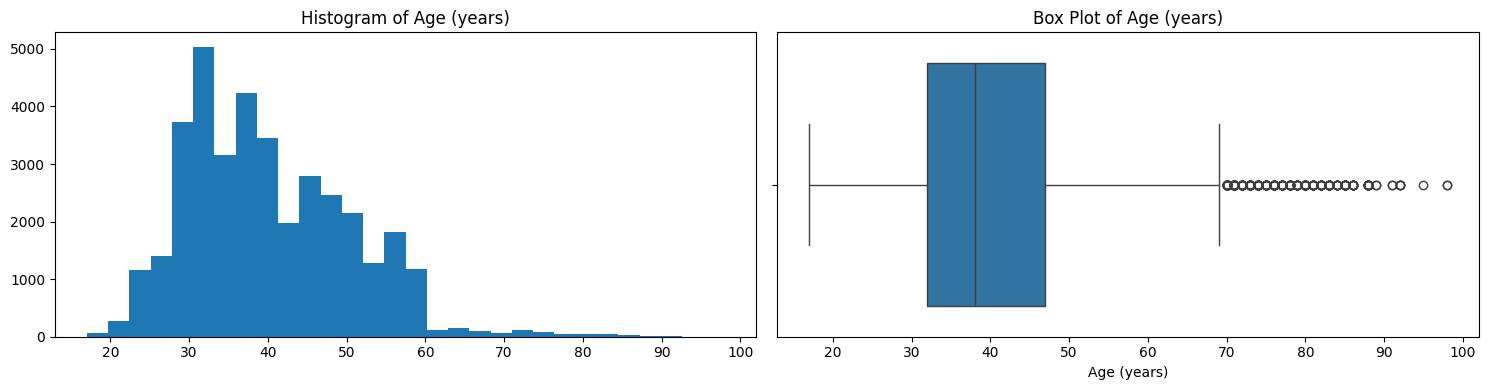

NaN fraction for Campaign Calls: 0 / 36991


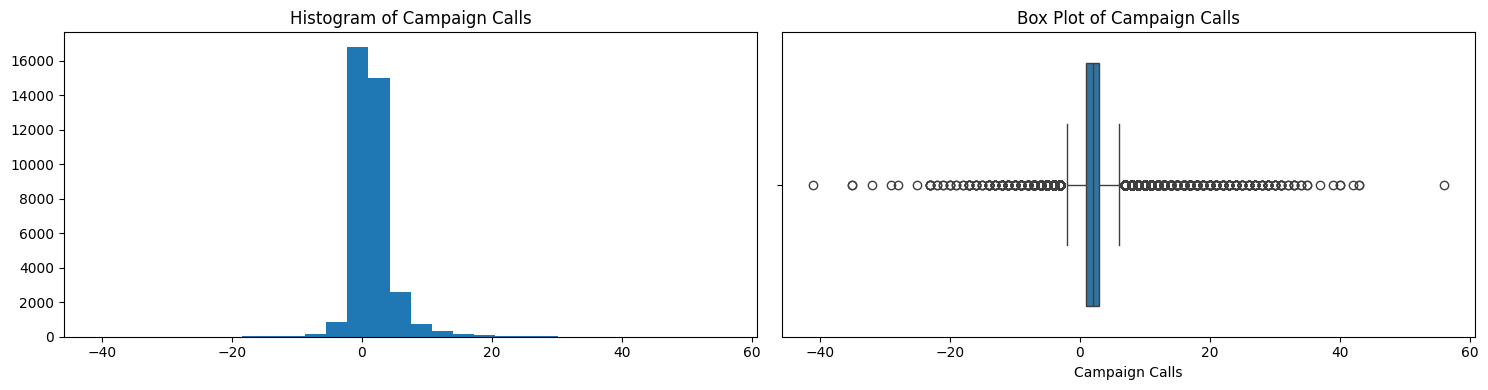

NaN fraction for Previous Contact Days: 35618 / 36991


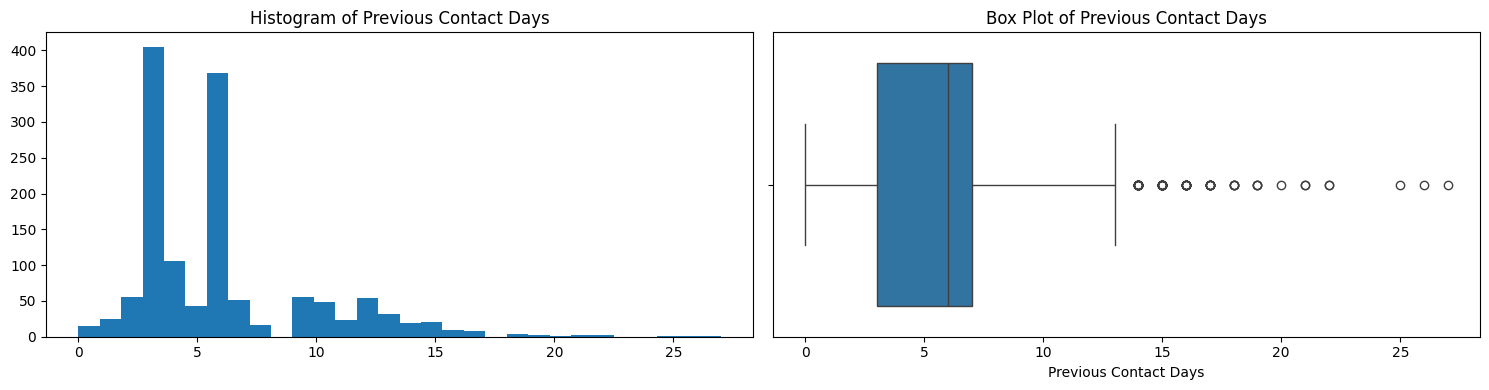

NA fraction for Credit Default: 7716 / 36991


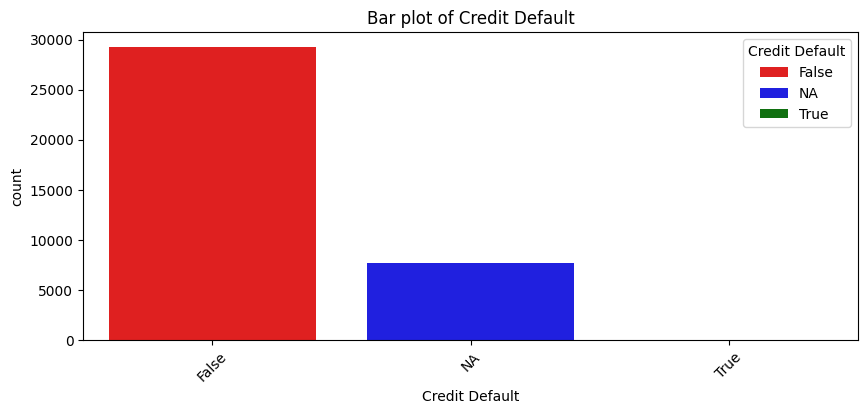

NA fraction for Housing Loan: 22659 / 36991


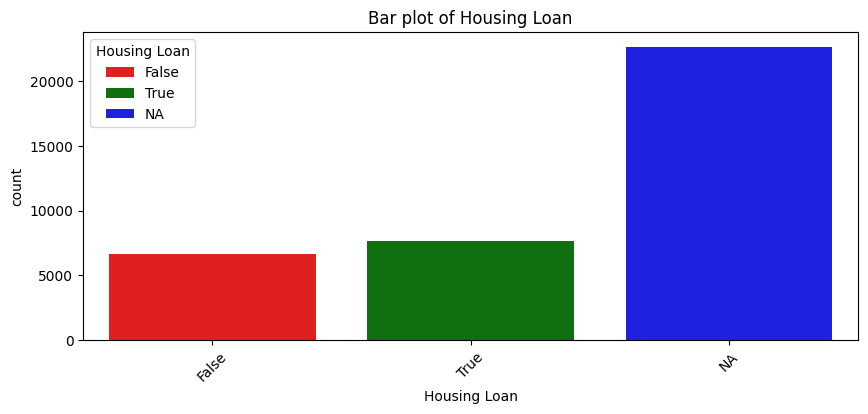

NA fraction for Personal Loan: 4523 / 36991


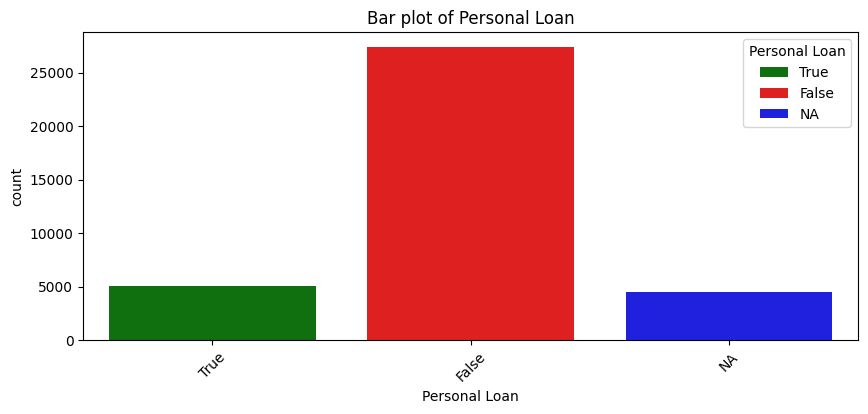

NA fraction for Contact Method: 0 / 36991


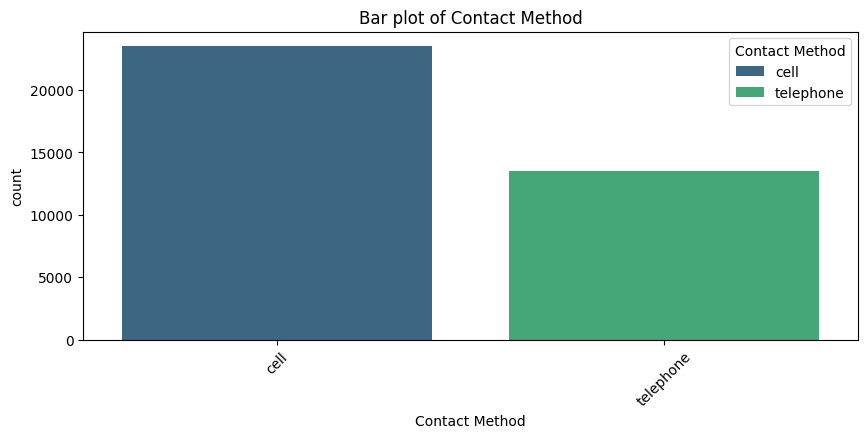

NA fraction for Education Level: 1575 / 36991


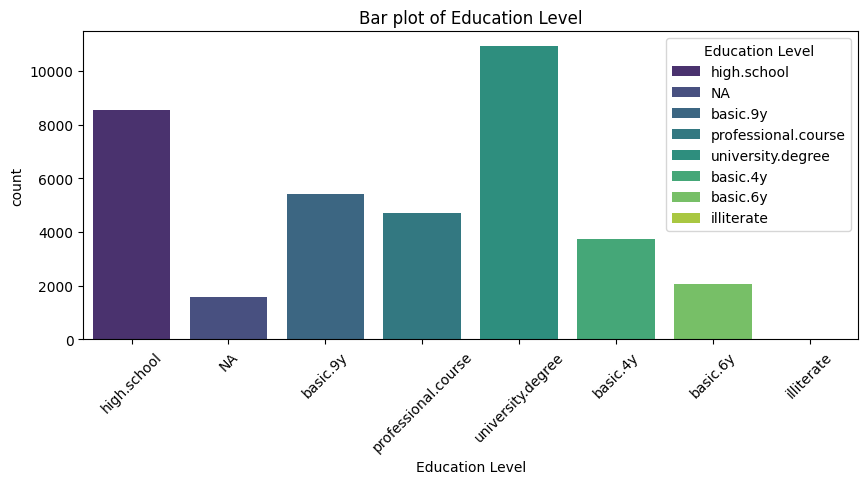

NA fraction for Marital Status: 71 / 36991


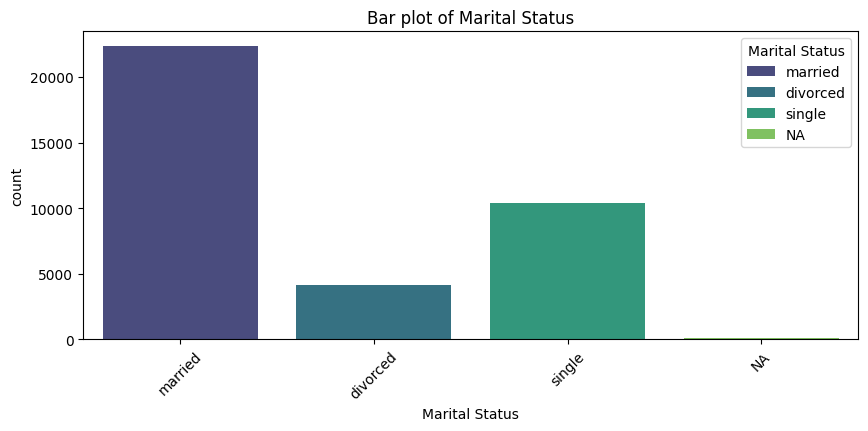

NA fraction for Occupation: 299 / 36991


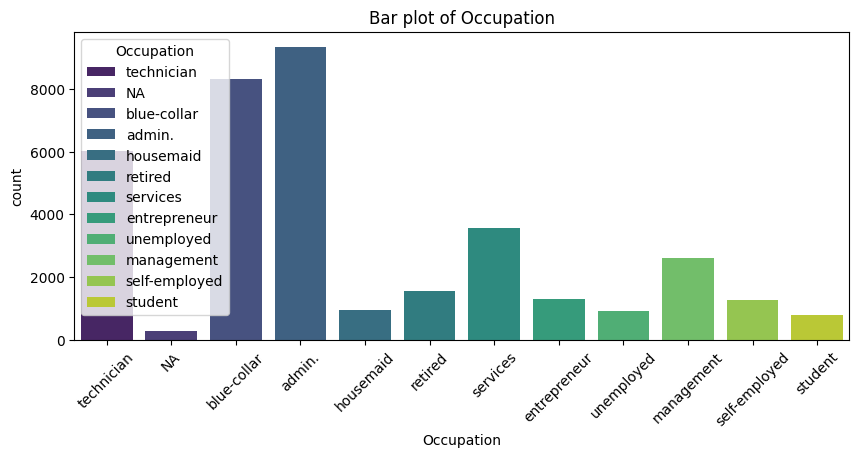

In [39]:
# Distribution for numerical data
def plot_num_features(df: pd.DataFrame, num_features: list[str]):
    for col in num_features:
        plt.figure(figsize=(15, 4))

        # Count the NaN values in the column
        nan_count = df[col].isna().sum()
        print(f'NaN fraction for {col}: {nan_count} / {df.shape[0]}')

        # Histogram
        plt.subplot(1, 2, 1)
        df[col].hist(grid=False, bins=30)
        plt.title(f'Histogram of {col}')

        # Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f'Box Plot of {col}')

        plt.tight_layout()
        plt.show()
plot_num_features(processed_df, num_features)

# Distribution for boolean data
def plot_bool_features(df: pd.DataFrame, bool_features: list[str]):
    for col in bool_features:
        plt.figure(figsize=(10, 4))

        # Count the NA values in the column
        nan_count = df[col].isna().sum()
        print(f'NA fraction for {col}: {nan_count} / {df.shape[0]}')

        # Bar 
        temp = df[[col]].copy().astype("object")
        temp[col] = np.where(temp[col] == 1, True, np.where(temp[col] == 0, False, "NA"))
        sns.countplot(data=temp, x=col, hue=col, palette={'True': "green", 'False': "red", "NA": "blue"}, legend=True)
        plt.title(f'Bar plot of {col}')
        plt.xticks(rotation=45)

        plt.show()
plot_bool_features(processed_df, bool_features)

# Distribution for categorical data
def plot_cat_features(df: pd.DataFrame, cat_features: list[str]):
    for col in cat_features:
        plt.figure(figsize=(10, 4))

        # Count the NA values in the column
        nan_count = df[col].isna().sum()
        print(f'NA fraction for {col}: {nan_count} / {df.shape[0]}')

        # Bar 
        temp = df[[col]].copy()
        temp.fillna("NA", inplace=True)
        sns.countplot(data=temp, x=col, hue=col, palette='viridis', legend=True)
        plt.title(f'Bar plot of {col}')
        plt.xticks(rotation=45)

        plt.show()
plot_cat_features(processed_df, cat_features)

Post-univariate-analysis data stored in post_ua_df

We convert -ve values in Campaign Calls to +ve.  

We apply transformation to help in normalization since the numerical features are highly skewed and have a large range.

For Campaign Calls_log, the problem is that the mode is the min as well as from the graph, so there's no way as far as I know to correct the imbalance. I can tell that the mode is the min too from Q1 = min after i run display(post_ua_df.describe(include="all").T) in the 3rd line

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age (years),36991.0,NaN,NaN,NaN,40.025303,10.436777,17.0,32.0,38.0,47.0,98.0
Occupation,36692,11,admin.,9356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,36920,3,married,22347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,35416,7,university.degree,10924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,29275,2,False,29272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing Loan,14332,2,True,7688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Personal Loan,32468,2,False,27427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,36991,2,cell,23496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls,36991.0,NaN,NaN,NaN,2.572355,2.776967,1.0,1.0,2.0,3.0,56.0
Previous Contact Days,1373.0,NaN,NaN,NaN,5.961398,3.810465,0.0,3.0,6.0,7.0,27.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age (years)_log,36991.0,NaN,NaN,NaN,3.683195,0.247767,2.890372,3.496508,3.663562,3.871201,4.59512
Occupation,36692,11,admin.,9356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,36920,3,married,22347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,35416,7,university.degree,10924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,29275,2,False,29272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Housing Loan,14332,2,True,7688,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Personal Loan,32468,2,False,27427,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,36991,2,cell,23496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls_log,36991.0,NaN,NaN,NaN,1.119948,0.491928,0.693147,0.693147,1.098612,1.386294,4.043051
Previous Contact Days_log,1373.0,NaN,NaN,NaN,1.806656,0.519696,0.0,1.386294,1.94591,2.079442,3.332205


features: Index(['Age (years)_log', 'Occupation', 'Marital Status', 'Education Level',
       'Credit Default', 'Housing Loan', 'Personal Loan', 'Contact Method',
       'Campaign Calls_log', 'Previous Contact Days_log'],
      dtype='object')
bool_features: Index(['Credit Default', 'Housing Loan', 'Personal Loan'], dtype='object')
cat_features: Index(['Contact Method', 'Education Level', 'Marital Status', 'Occupation'], dtype='object')
num_features: Index(['Age (years)_log', 'Campaign Calls_log', 'Previous Contact Days_log'], dtype='object')
NaN fraction for Age (years)_log: 0 / 36991


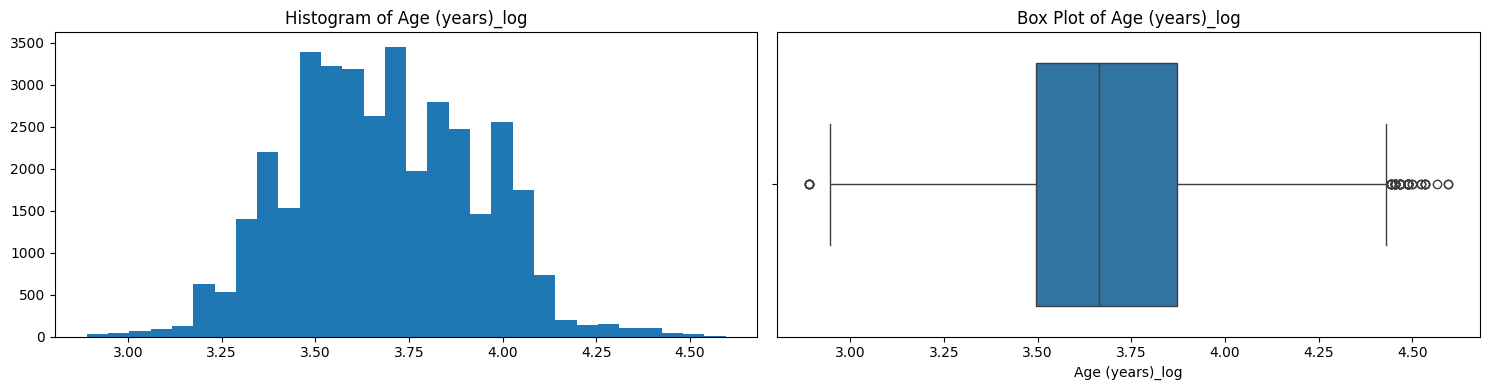

NaN fraction for Campaign Calls_log: 0 / 36991


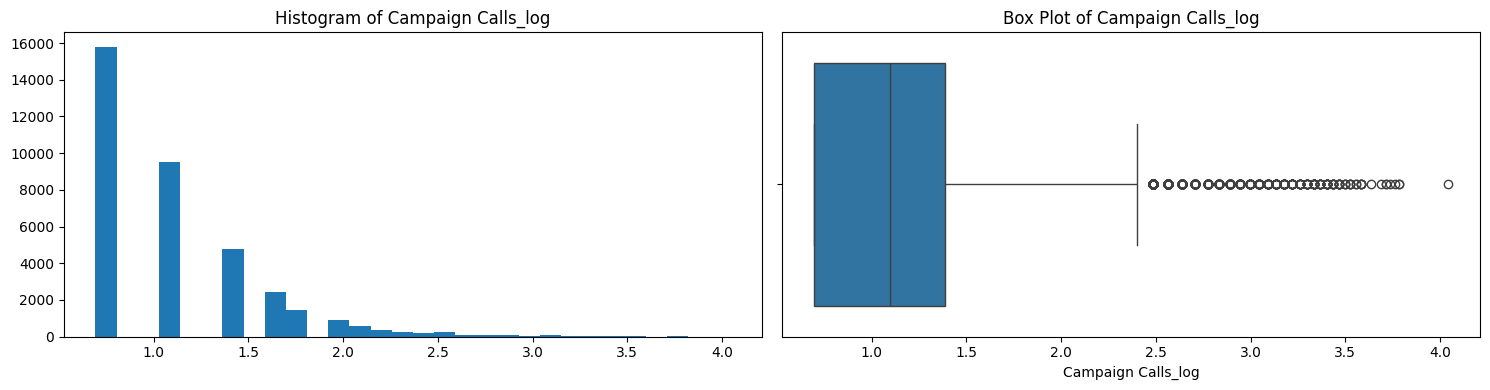

NaN fraction for Previous Contact Days_log: 35618 / 36991


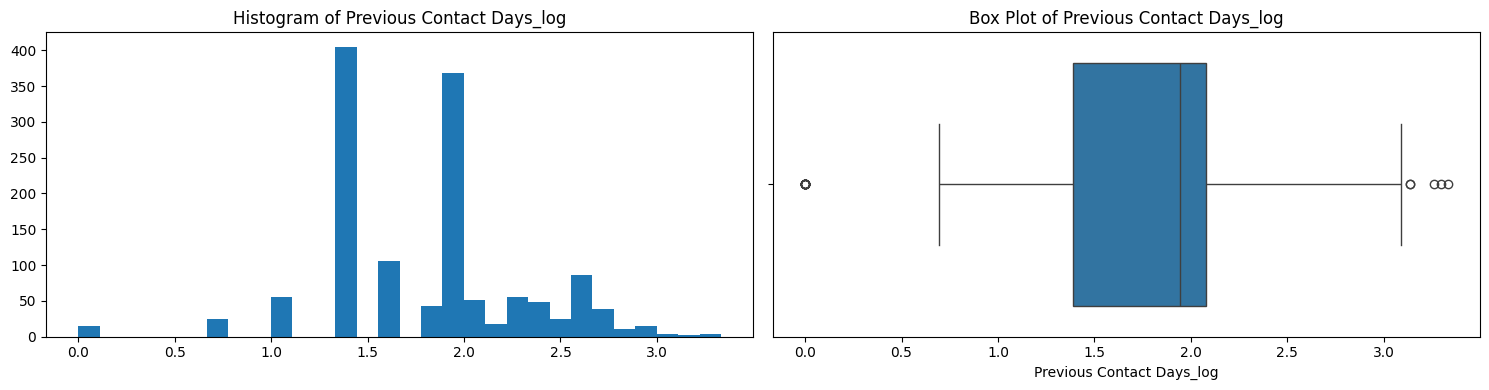

In [104]:
post_ua_df = processed_df.copy()

post_ua_df["Campaign Calls"] = post_ua_df["Campaign Calls"].apply(lambda x: abs(x))
display(post_ua_df.describe(include="all").T)

post_ua_df['Age (years)'] = np.log1p(post_ua_df['Age (years)'])
post_ua_df.rename(columns={"Age (years)": "Age (years)_log"}, inplace=True)
post_ua_df['Campaign Calls'] = np.log1p(post_ua_df['Campaign Calls'])
post_ua_df.rename(columns={"Campaign Calls": "Campaign Calls_log"}, inplace=True)
post_ua_df['Previous Contact Days'] = np.log1p(post_ua_df['Previous Contact Days'])
post_ua_df.rename(columns={"Previous Contact Days": "Previous Contact Days_log"}, inplace=True)


display(post_ua_df.describe(include="all").T)
features, bool_features, cat_features, num_features = get_features(post_ua_df)
plot_num_features(post_ua_df, num_features)

Summarise processed data (Bivariate Analysis)

No correlation between anything apart from

Age (Years) having a negative correlation with Campaign Calls if we treat -ve values of the latter as +ve

<Figure size 1300x1700 with 0 Axes>

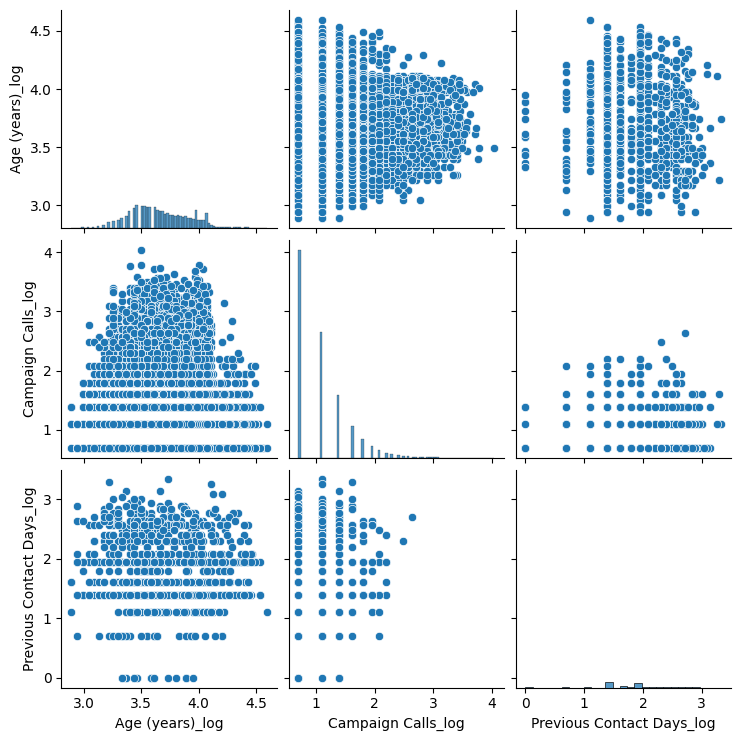

In [72]:
plt.figure(figsize=(13,17))
sns.pairplot(data=post_ua_df[num_features])
plt.show()

Summarise processed data (Bivariate Analysis)

We now visualize target vs feature

Rationale: Same as above

NaN fraction for Age (years)_log: 0 / 36991


<Figure size 800x600 with 0 Axes>

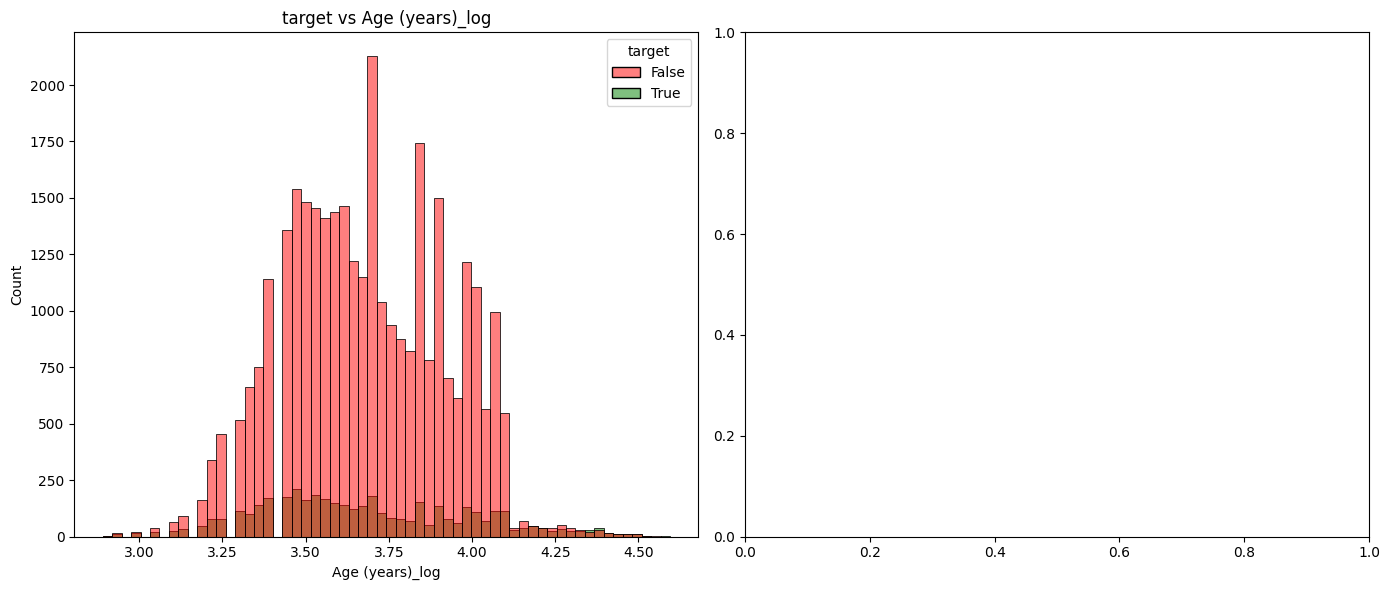

NaN fraction for Campaign Calls_log: 0 / 36991


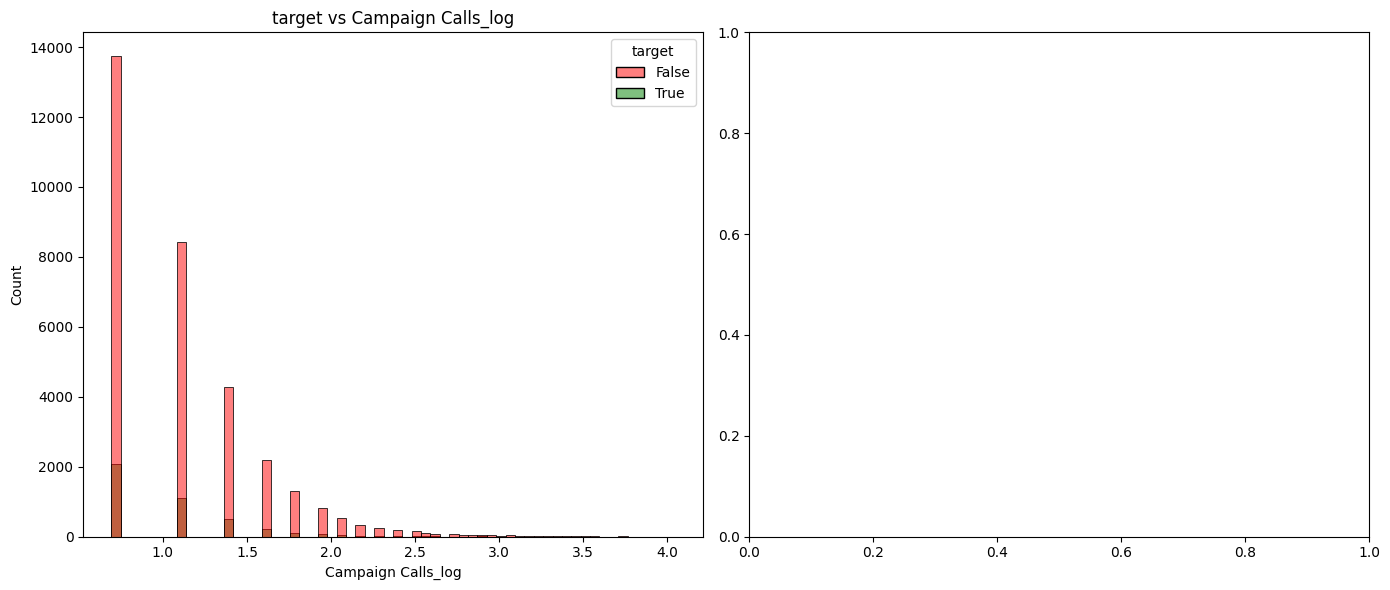

NaN fraction for Previous Contact Days_log: 35618 / 36991


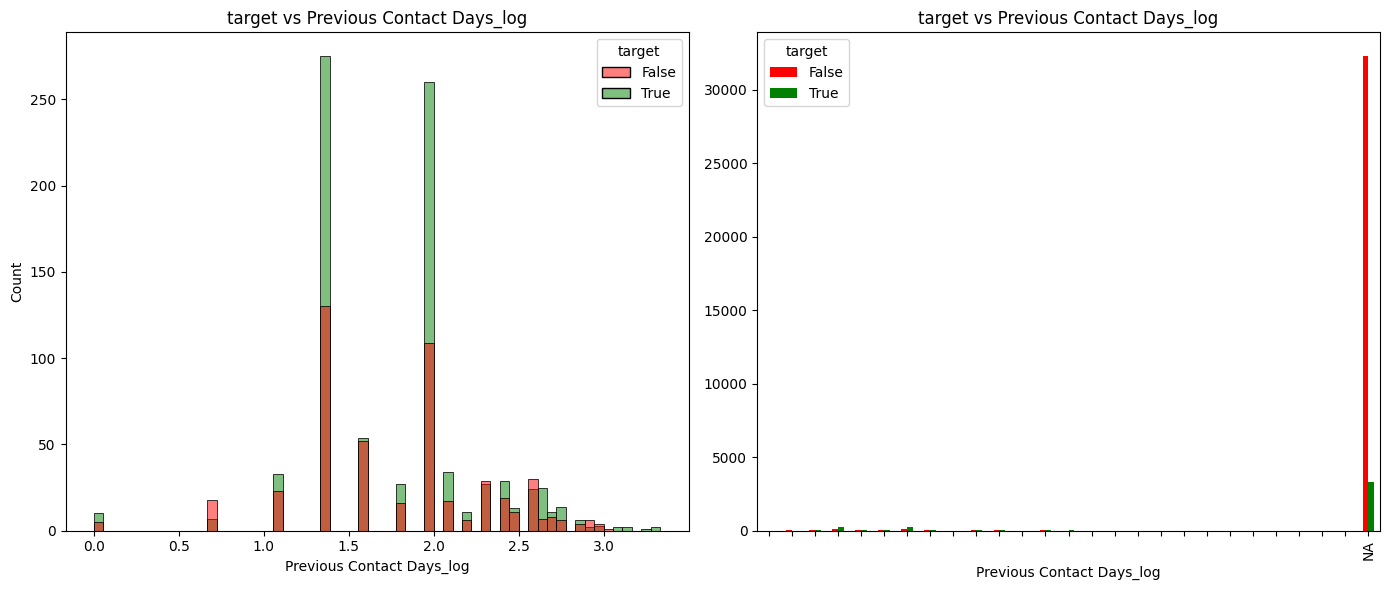

Credit Default  target
False           False     25479
                True       3793
True            False         3
NA              False      7318
                True        398
dtype: int64
Housing Loan  target
False         False      5893
              True        751
True          False      6780
              True        908
NA            False     20127
              True       2532
dtype: int64
Personal Loan  target
False          False     24287
               True       3140
True           False      4487
               True        554
NA             False      4026
               True        497
dtype: int64
Contact Method  target
cell            False     20017
                True       3479
telephone       False     12783
                True        712
dtype: int64
Education Level      target
NA                   False     1348
                     True       227
basic.4y             False     3349
                     True       385
basic.6y             False     18

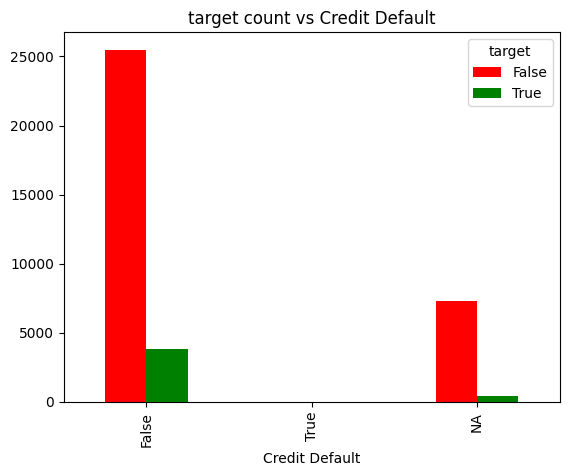

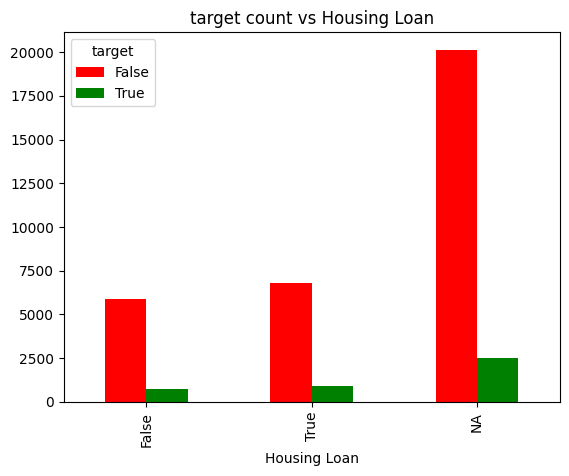

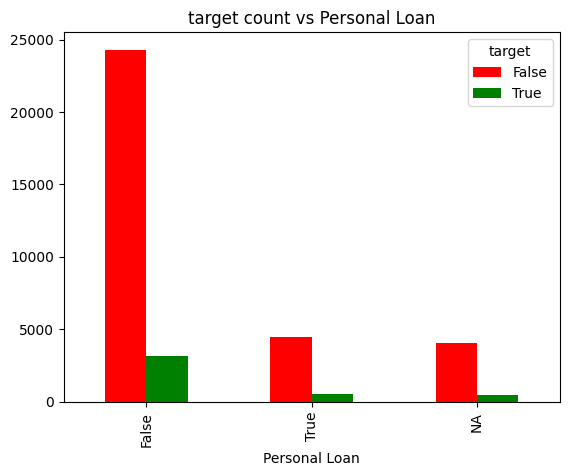

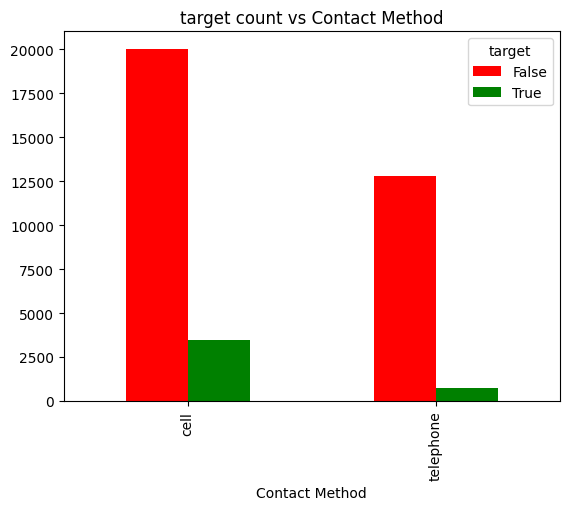

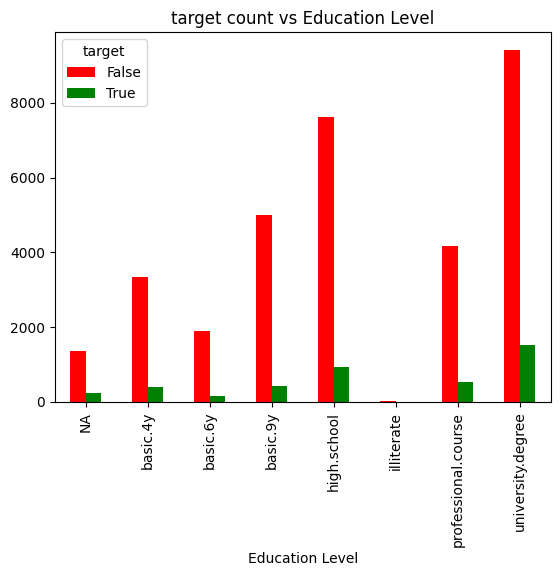

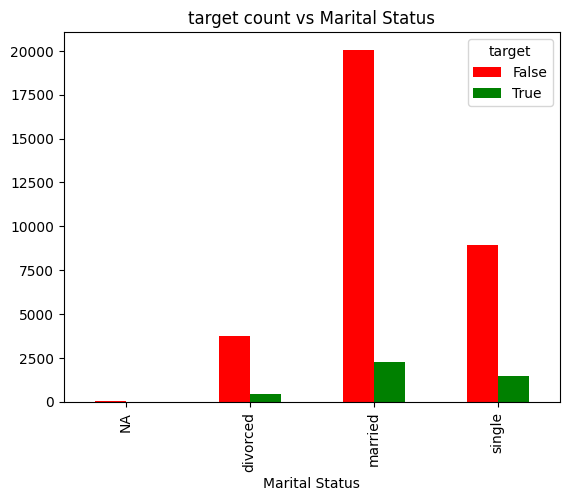

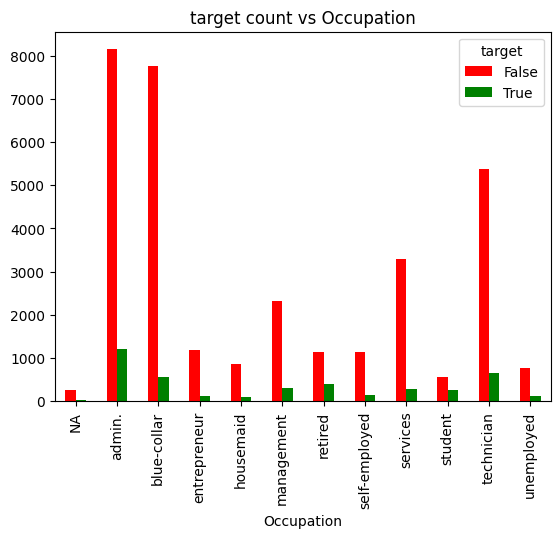

In [73]:
plt.figure(figsize=(8, 6))

for feature in num_features:
    # Create subplots with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the size as needed
    
    nan_count = post_ua_df[feature].isna().sum()
    print(f'NaN fraction for {feature}: {nan_count} / {post_ua_df.shape[0]}')
    
    # target vs feature overlayed histo
    sns.histplot(data=post_ua_df, x=feature, hue=target, bins=60, multiple="layer", palette={0: "red", 1: "green"}, ax=axes[0])
    axes[0].set_title(f'{target} vs {feature}')

    # target vs feature grouped bar with NaN
    if nan_count > 0:
        temp = post_ua_df[[feature, target]].copy()
        temp[feature] = temp[feature].fillna("NA")
        temp = temp.groupby([feature, target]).size()
        temp = temp.unstack(fill_value=0)
        temp.plot(kind='bar', stacked=False, color=['red', 'green'], ax=axes[1])
        axes[1].set_title(f'{target} vs {feature}')
        labels = axes[1].get_xticklabels()
        for i, label in enumerate(labels):
            if label.get_text() != 'NA':  # Hide all labels except 'NA'
                label.set_visible(False)
    plt.tight_layout()
    plt.show()

for feature in np.concatenate((bool_features, cat_features)):
    # target vs feature grouped bar
    if feature == target:
        continue
    temp = post_ua_df[[feature, target]].copy()
    temp[feature] = temp[feature].fillna("NA")
    temp = temp.groupby([feature, target]).size()
    print(temp)
    temp = temp.unstack(fill_value=0)
    temp.plot(kind='bar', stacked=False, color=['red', 'green'])
    plt.title(f'{target} count vs {feature}')

plt.show()

Summarise processed data (Bivariate Analysis)

For Age (years)_log, Campaign Calls_log, Credit Default, Housing Loan, Personal Loan, Occupation, Marital Status, Education Level, and Contact Method. it seems that these features have poor discriminatory power as the chance of being subscribed or unsubscribed does not vary significantly as each feature varies, based off my visual observation which is unreliable. However, this still makes me required to perform more tests to see if I'll need to drop the features.

For the numerical features like Age (years)_log, I'll perform a t-Test and Mann-Whitney U test. The idea behind these tests is to test whether or not the distribution of values for subscribed and unsubscribed users is different to a confidence level. If they are, then I can say with confidence that since there is a difference in the values for unsubscribed and subscribed users, this must mean that the model can use these values to give different probability values for subscribed and unsubscribed users. 

For instance, if my p-value is <0.05 for Age (years)_log for both of the tests, I can confidently say that the distribution for Age (years)_log is not the same for unsubscribed and subscribed users. This must mean that there can be different age groups that give different probabilities for being subscribed or not.

From the test, we can conclude that due to the low p-value of Age (years)_log and Campaign Calls_log, that these 2 features have discriminatory power, and we should keep these features. However, for Previous Contact Days_log, the p-value is high at >0.9, so this means the feature should have no discriminatory power. However, the test samples are the non NaN values. We can see off our visualization for the target vs Previous Contact Days_log graph that when Previous Contact Days_log is NA, the chances of being unsubscribed is high compared to when there's a valid value for Previous Contact Days_log which causes the chance of being subscribed to be high instead. This means that Previous Contact Days_log does indeed have a discriminatory power when we treat NA as a category, so we keep this feature and in our pipeline we must remember to use one-hot encoding to allow our model to learn from Previous Contact Days_log. 

For everything else, we'll just perform chi-square test. If the p-value is <0.05 we can safely conclude that the the proportion of subscribed users in a category group does not vary significantly as the group varies.

For instance, we can see that for Housing Loan, no matter if you pick NA, True, or False, the proportion of subscribed users remain roughly the same at 0.11, and as expected, it'll perform poorly on the chi square test. It has a high p-value of 0.3, so we'll drop it. The same can be said for Personal Loan. They both have poor discriminatory power.

In [114]:
# Perform t-Test and Mann-Whitney U test form num_features
print(f"Performing t-Test and Mann-Whitney U test for num_features: {num_features}\n")
dropped_na_post_ua_df = post_ua_df.dropna()
for feature in num_features:
    class_0 = dropped_na_post_ua_df[dropped_na_post_ua_df[target] == 0][feature]
    class_1 = dropped_na_post_ua_df[dropped_na_post_ua_df[target] == 1][feature]
    print(f"Distribution of unsubscribed users for {feature}")
    display(class_0.describe().T)
    print(f"Distribution of subscribed users for {feature}")
    display(class_1.describe().T)
    u_stat, p_value = stats.mannwhitneyu(class_0, class_1)
    print(f"Mann-Whitney U statistic: {u_stat}, P-value: {p_value}")
    t_stat, p_value = stats.ttest_ind(class_0, class_1)
    print(f"T-statistic: {t_stat}, P-value: {p_value}\n")

temp = np.concatenate((bool_features, cat_features))
print(f"Testing other features: {temp}")
filled_na_post_ua_df = post_ua_df.fillna("NA")
for feature in temp:
    group_counts = filled_na_post_ua_df[[feature, target]].copy().groupby([feature, target]).size().unstack(fill_value=0)
    group_counts['True Probability'] = group_counts[True] / (group_counts[True] + group_counts[False])
    print(f"\nProportion of subscribed for feature '{feature}':\n")
    print(group_counts[['True Probability']])
    
    correction = (not group_counts[(group_counts[True] + group_counts[False]) < 5].empty)
    contingency_table = pd.crosstab(filled_na_post_ua_df[feature], filled_na_post_ua_df[target])
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table, correction=correction)
    print(f"correction: {correction}")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")

Performing t-Test and Mann-Whitney U test for num_features: Index(['Age (years)_log', 'Campaign Calls_log', 'Previous Contact Days_log'], dtype='object')

Distribution of unsubscribed users for Age (years)_log


count    151.000000
mean       3.629922
std        0.297923
min        2.890372
25%        3.401197
50%        3.583519
75%        3.860674
max        4.369448
Name: Age (years)_log, dtype: float64

Distribution of subscribed users for Age (years)_log


count    293.000000
mean       3.757110
std        0.361649
min        2.944439
25%        3.465736
50%        3.761200
75%        4.077537
max        4.454347
Name: Age (years)_log, dtype: float64

Mann-Whitney U statistic: 17596.0, P-value: 0.00040932650210160026
T-statistic: -3.7193374737321743, P-value: 0.00022545802013608756

Distribution of unsubscribed users for Campaign Calls_log


count    151.000000
mean       1.046045
std        0.378561
min        0.693147
25%        0.693147
50%        1.098612
75%        1.386294
max        2.197225
Name: Campaign Calls_log, dtype: float64

Distribution of subscribed users for Campaign Calls_log


count    293.000000
mean       0.939582
std        0.306889
min        0.693147
25%        0.693147
50%        0.693147
75%        1.098612
max        2.079442
Name: Campaign Calls_log, dtype: float64

Mann-Whitney U statistic: 25389.5, P-value: 0.005397769418270272
T-statistic: 3.1919484869872794, P-value: 0.0015139870915498903

Distribution of unsubscribed users for Previous Contact Days_log


count    151.000000
mean       1.799885
std        0.540390
min        0.000000
25%        1.386294
50%        1.945910
75%        2.079442
max        2.995732
Name: Previous Contact Days_log, dtype: float64

Distribution of subscribed users for Previous Contact Days_log


count    293.000000
mean       1.804437
std        0.513740
min        0.000000
25%        1.386294
50%        1.945910
75%        1.945910
max        3.295837
Name: Previous Contact Days_log, dtype: float64

Mann-Whitney U statistic: 22112.5, P-value: 0.9945497584041735
T-statistic: -0.08690648498356104, P-value: 0.9307852010223778

Testing other features: ['Credit Default' 'Contact Method' 'Education Level' 'Marital Status'
 'Occupation']

Proportion of subscribed for feature 'Credit Default':

target          True Probability
Credit Default                  
False                   0.129578
True                    0.000000
NA                      0.051581
correction: True
Chi-square statistic: 370.1570
P-value: 0.0000
Degrees of freedom: 2

Proportion of subscribed for feature 'Contact Method':

target          True Probability
Contact Method                  
cell                    0.148068
telephone               0.052760
correction: False
Chi-square statistic: 775.0421
P-value: 0.0000
Degrees of freedom: 1

Proportion of subscribed for feature 'Education Level':

target               True Probability
Education Level                      
NA                           0.144127
basic.4y

Post-bivariate-analysis data stored in post_ba_df

We drop Housing Loan and Personal Loan due to poor discriminatory power as explained above.

In [113]:
post_ba_df = post_ua_df.copy()
post_ba_df.drop('Housing Loan', axis=1, inplace=True)
post_ba_df.drop('Personal Loan', axis=1, inplace=True)
display(post_ba_df.describe(include="all").T)
print_column_uniques(post_ba_df)

features, bool_features, cat_features, num_features = get_features(post_ba_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age (years)_log,36991.0,NaN,NaN,NaN,3.683195,0.247767,2.890372,3.496508,3.663562,3.871201,4.59512
Occupation,36692,11,admin.,9356,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital Status,36920,3,married,22347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education Level,35416,7,university.degree,10924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit Default,29275,2,False,29272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Contact Method,36991,2,cell,23496,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Campaign Calls_log,36991.0,NaN,NaN,NaN,1.119948,0.491928,0.693147,0.693147,1.098612,1.386294,4.043051
Previous Contact Days_log,1373.0,NaN,NaN,NaN,1.806656,0.519696,0.0,1.386294,1.94591,2.079442,3.332205
target,36991,2,False,32800,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Column: Age (years)_log
[4.06044301 4.02535169 3.52636052 3.61091791 3.33220451 4.07753744
 3.8918203  3.21887582 3.55534806 3.76120012 3.78418963 3.29583687
 3.63758616 3.8501476  4.09434456 3.91202301 3.4339872  3.95124372
 3.8286414  3.4657359  3.73766962 3.66356165 3.87120101 4.24849524
 3.93182563 3.25809654 3.68887945 3.80666249 3.97029191 3.58351894
 4.35670883 3.71357207 4.04305127 3.98898405 4.11087386 3.40119738
 3.36729583 4.00733319 3.49650756 4.40671925 4.15888308 3.09104245
 3.13549422 4.31748811 4.39444915 4.14313473 4.2341065  4.46590812
 3.17805383 4.27666612 4.21950771 4.18965474 3.04452244 2.99573227
 4.20469262 4.33073334 2.94443898 4.29045944 4.26267988 4.41884061
 4.4543473  4.12713439 4.48863637 4.4308168  4.36944785 4.17438727
 2.89037176 4.34380542 4.30406509 4.38202663 4.49980967 4.44265126
 4.52178858 4.59511985 4.53259949 4.56434819]

Column: Occupation
['technician' None 'blue-collar' 'admin.' 'housemaid' 'retired' 'services'
 'entrepreneur' 'unemployed' 'm

Summarise processed data (Multivariate Analysis)

All our variables seem to be statistically independent which is nice for Multiple Linear Regression.

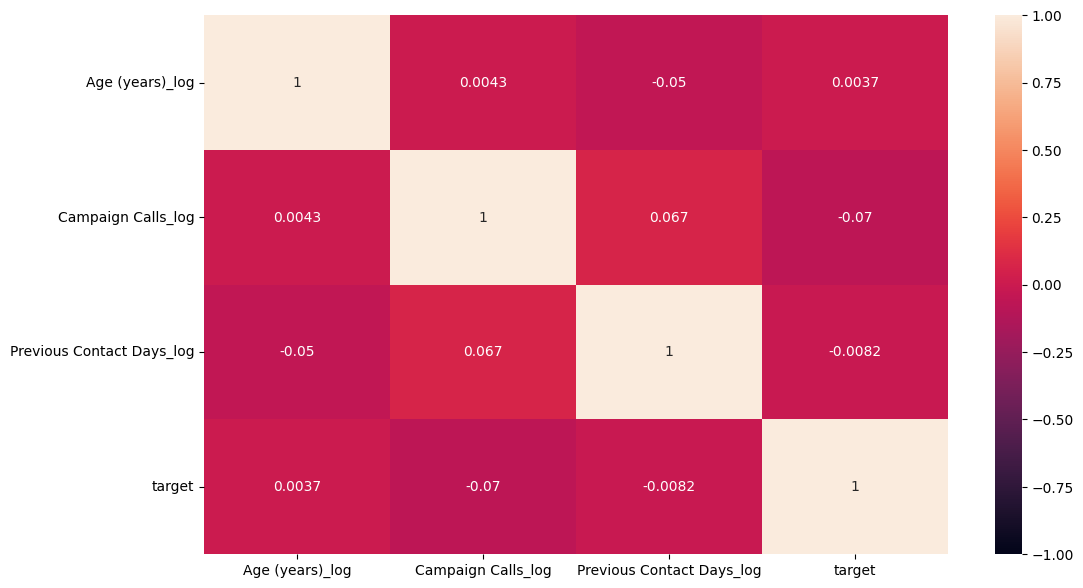

In [115]:
plt.figure(figsize=(12, 7))
sns.heatmap(post_ba_df.drop(np.concat((cat_features, bool_features)), axis=1).corr(), annot = True, vmin = -1, vmax = 1)
plt.show()